In [1]:
from astropy import units as u
from poliastro.bodies import Earth, Sun
from poliastro.twobody import Orbit
from poliastro.plotting import OrbitPlotter3D
from poliastro.core.events import line_of_sight
import plotly.io as pio
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt

INT_CLOCK = 1672531200  # 01.01.2023

class satellite:
    def __init__(self, a, ecc, inc, raan, argp, nu, name='UNKNWON SAT'):
        # Initiate orbit object
        self.orb = Orbit.from_classical(Earth, a, ecc, inc, raan, argp, nu)
        self.name = name    # satellite name
        self.int_clock =   INT_CLOCK   # internal clock

    def propagate(self, time):
        self.orb = self.orb.propagate(time * u.s)   # propagate position
        return None

    def skycoord(self):
        satx, saty, satz = self.orb.r    # coordinates (cartesian reference)
        # create coordinate object
        sat_sc = SkyCoord(x=satx, y=saty, z=satz,
                          representation_type='cartesian')
        sat_sc.representation_type = 'spherical'
        sat_sc.ra.wrap_angle = 180 * u.degree  # angles +/-180deg
        sat_sc.dec.wrap_angle = 90 * u.degree  # angles +/-90deg
        return sat_sc


class ground_station:
    def __init__(self, lat, lon, alt=0, name='UNKNOWN GS'):
        """
        altitude in meters
        """
        self.lat = lat  # latitude earth fixed
        self.lon = lon  # longitude earth fixed
        self.lon_IRF = lon  # longitude in inertial reference frame
        self.alt = alt  # altitude in meters

        # Create the coordinate objects
        self.gs = coord.EarthLocation.from_geodetic(lon=lon*u.degree,
                                                    lat=lat*u.degree)
        self.gs_skycoord = SkyCoord(ra=self.gs.lon,   # ra = longitude
                                    dec=self.gs.lat,  # dec = latitude
                                    distance=6371*u.km + alt*u.m)
        self.gs_skycoord_cartesian = copy.deepcopy(self.gs_skycoord)
        self.gs_skycoord_cartesian.representation_type = 'cartesian'
        self.name = name    # Ground Station name
        self.int_clock = INT_CLOCK  # internal clock 01.01.2023

    def skycoord(self):
        return self.gs_skycoord
    
    def skycoord_cartesian(self):
        return self.gs_skycoord_cartesian

    def propagate(self, time):
        self.int_clock += time  # update internal clock
        # update longitude due to earth rotation.
        self.lon_IRF = (self.lon_IRF + time/(24*60*60) * 360) % 360
        # update coordinate object
        self.gs = coord.EarthLocation.from_geodetic(lon=self.lon_IRF*u.degree,
                                                    lat=self.lat*u.degree)
        self.gs_skycoord = SkyCoord(ra=self.gs.lon,   # ra = longitude
                                    dec=self.gs.lat,  # dec = latitude
                                    distance=6371*u.km + self.alt*u.m)
        self.gs_skycoord.ra.wrap_angle = 180 * u.degree
        self.gs_skycoord.dec.wrap_angle = 90 * u.degree

        self.gs_skycoord_cartesian = self.gs_skycoord
        self.gs_skycoord_cartesian.representation_type = 'cartesian'
        return None

    def transmission(self):
        return None


class sched_transm_gs(ground_station):
    def __init__(self, lat, lon, alt=0, name='UNKNOWN GS'):
        super().__init__(lat, lon, alt, name)
        self.sched_time = 60 * 10   # schedul transm interval in seconds
        self.last_trnsmt = self.int_clock
        self.repeat = 0     # Number of message repeats
        self.repeat_count = 0   # Counter for repeated messages
        self.msg_id = -1     # message ID

    def dgp(self):      # Data Generation Process
        return np.random.randint(0, 25)

    def transmission(self):
        if self.int_clock - self.last_trnsmt > self.sched_time:
            # Run this every sched_time seconds
            self.msg_id += 1
            self.last_trnsmt = self.int_clock
            self.data = [self.dgp(), [self.lat, self.lon]]
            self.repeat_count = self.repeat
            return self.data, self.msg_id
        elif self.repeat_count > 0:
            # Run this when the repeat counter is positive
            # (i.e. we repeat the last transmission)
            self.repeat_count -= 1
            return self.data, self.msg_id
        else:
            return None, None


In [2]:
N_constellation = 4
gs_coord_lst = [[45.5, 10.2], [50, 8], [70, -110], [75, -112]]
sats = list()

a = 6928 * u.km
ecc = 0 * u.one
inc = 97.59 * u.deg
raan = 270 * u.deg
argp = 0 * u.deg
nu = -180 * u.deg

sats = list()
for i in range(N_constellation):
    sats.append(satellite(a, ecc, inc, raan, argp,
                          nu + 360*i/N_constellation * u.deg,
                          name='PICO'+str(i)))

sat_names = [sat.name for sat in sats]

gss = list()
for i in range(len(gs_coord_lst)):
    gss.append(sched_transm_gs(gs_coord_lst[i][0],
               gs_coord_lst[i][1], 100, 'GS' + str(i)))

# gs = ground_station(45.5, 10.2, 0, 'Brescia 01')
# gs = sched_transm_gs(45.5, 10.2, 0, 'Brescia 01')

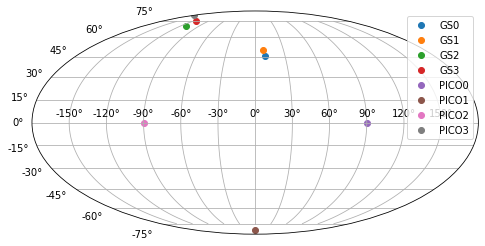

In [6]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
[ax.scatter(gs.gs.lon.radian, gs.gs.lat.radian, label="GS"+str(i)) for gs, i in zip(gss, range(len(gss))) ]
[ax.scatter(sat.skycoord().ra.radian, sat.skycoord().dec.radian, label=sat.name) for sat in sats ]
# ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)
ax.legend()

In [7]:
t_stp = 60  # seconds
sim_steps = 1000  # simulation steps
data_row = {'msg_id': -1, 'data': np.nan, 'time': np.nan,
            'latitude': np.nan, 'longitude': np.nan}
[data_row.update({sat.name: 0}) for sat in sats]
keys = list(data_row.keys())
data_lst = list()

In [8]:
for stp in range(sim_steps):
    for sat in sats:
        sat.propagate(t_stp)    # propagate all satellites
    for gs in gss:
        gs.propagate(t_stp)     # propagate all ground stations

    for gs in gss:
        gs_sc = gs.skycoord()
        data, id = gs.transmission()
        data_tmp_row = copy.deepcopy(data_row)
        data_tmp_row.update({'latitude': gs.lat, 'longitude': gs.lon,
                            'time': gs.int_clock})
        for sat in sats:
            los_evnt = line_of_sight([gs_sc.x, gs_sc.y, gs_sc.z] * u.km,
                                     sat.orb.r, 6371*u.km)
            if los_evnt >= 0 and data is not None:
                # print(f'Satellite {sat.name} received {data}')
                distance = gs_sc.separation_3d(sat.skycoord())
                data_tmp_row.update({'msg_id': id, sat.name: distance})
        if data_tmp_row['msg_id'] != -1:
            dicti = copy.deepcopy(data_tmp_row)
            for key in keys:
                if key not in sat_names:
                    dicti.pop(key)
                elif dicti[key] == 0:
                    dicti.pop(key)
            dicti_values = {key: i for (key, _), i in
                            zip(sorted(dicti.items(),
                                    key=lambda item: item[1]),
                                range(1, len(dicti)+1))}
            data_tmp_row.update(dicti_values)
            data_lst.append(data_tmp_row)

df = pd.DataFrame(data_lst)

In [9]:
df

,msg_id,data,time,latitude,longitude,PICO0,PICO1,PICO2,PICO3
0,1,NaN,1672532520,70.0,-110.0,0,0,1,0
1,1,NaN,1672532520,75.0,-112.0,0,0,1,0
2,3,NaN,1672533840,70.0,-110.0,0,1,0,0
3,3,NaN,1672533840,75.0,-112.0,0,1,0,0
4,5,NaN,1672535160,70.0,-110.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
87,87,NaN,1672589280,50.0,8.0,0,0,1,0
88,88,NaN,1672589940,70.0,-110.0,0,0,1,0
89,88,NaN,1672589940,75.0,-112.0,0,0,1,0
90,89,NaN,1672590600,45.5,10.2,0,1,0,0
